In [2]:
from sumpy.recurrence import _make_sympy_vec, get_reindexed_and_center_origin_on_axis_recurrence, pde_to_ode_in_r, ode_in_r_to_x

from sumpy.expansion.diff_op import (
    laplacian,
    make_identity_diff_op,
)


import sympy as sp
from sympy import hankel1

import numpy as np

import math

import matplotlib.pyplot as plt
from matplotlib import cm, ticker

In [3]:
w = make_identity_diff_op(2)
laplace2d = laplacian(w)
n_init_lap, order_lap, recur_laplace = get_reindexed_and_center_origin_on_axis_recurrence(laplace2d)

w = make_identity_diff_op(2)
helmholtz2d = laplacian(w) + w
n_init_helm, order_helm, recur_helmholtz = get_reindexed_and_center_origin_on_axis_recurrence(helmholtz2d)

In [4]:
pde_to_ode_in_r(laplace2d)[0].simplify()

f_r1/sqrt(x0**2 + x1**2) + f_r2

In [5]:
ode_in_r_to_x(pde_to_ode_in_r(laplace2d)[0].simplify(), _make_sympy_vec("x",2), 2).simplify()

f_x1/x0 - f_x1*x1**2/x0**3 + f_x2 + f_x2*x1**2/x0**2

In [6]:
var = _make_sympy_vec("x", 2)
rct = sp.symbols("r_{ct}")
s = sp.Function("s")
n = sp.symbols("n")

In [7]:
def compute_derivatives(p):
    var = _make_sympy_vec("x", 2)
    var_t = _make_sympy_vec("t", 2)
    g_x_y = sp.log(sp.sqrt((var[0]-var_t[0])**2 + (var[1]-var_t[1])**2))
    derivs = [sp.diff(g_x_y,
                        var_t[0], i).subs(var_t[0], 0).subs(var_t[1], 0)
                        for i in range(p)]
    return derivs
l_max = 15
derivs_laplace = compute_derivatives(l_max)
derivs_laplace_dict = dict(zip([s(i) for i in range(l_max)], [derivs_laplace[i] for i in range(l_max)]))

In [8]:
def compute_rel_err(nsub, coord_dict):
    return abs((recur_laplace.subs(n, nsub).subs(derivs_laplace_dict).subs(coord_dict) - derivs_laplace[nsub].subs(coord_dict))/derivs_laplace[nsub].subs(coord_dict))

In [9]:
nsub = 14
coord_dict = {var[0]: 0.1 * np.random.rand(), var[1]: np.random.rand()}
recur_coeffs_lap = sp.poly(recur_laplace.subs(n, nsub), [s(i) for i in range(nsub - order_lap, nsub)]).coeffs()
#[i+nsub-order_lap for i in range(len(recur_coeffs_lap))]
coeffs_sub = [(recur_coeffs_lap[i]*derivs_laplace[i+nsub-order_lap]).subs(coord_dict) for i in range(len(recur_coeffs_lap))]
print(coeffs_sub)
ratio = np.abs(coeffs_sub[0]/coeffs_sub[1])
print("ratio: ", ratio, "||||| digits: ",np.log10(float(ratio)), "|||| pred error: 1e-"+str(int(16-np.ceil(np.log10(float(ratio))))))
print("rel. error: ", compute_rel_err(nsub, coord_dict))

[175427687040715., -4214735553825.07, -180235499771889.]
ratio:  41.6224659413107 ||||| digits:  1.619327806605522 |||| pred error: 1e-14
rel. error:  4.32943097294895e-16


In [10]:
c = sp.symbols("c")

In [25]:
nsub = 11
coord_dict_var = {var[0]: var[0], var[1]: c*var[0]}
recur_coeffs_lap_var = sp.poly(recur_laplace.subs(n, nsub), [s(i) for i in range(nsub - order_lap, nsub)]).coeffs()
#[i+nsub-order_lap for i in range(len(recur_coeffs_lap))]
coeffs_sub_var = [(recur_coeffs_lap_var[i]*derivs_laplace[i+nsub-order_lap]).subs(coord_dict_var) for i in range(len(recur_coeffs_lap_var))]

In [26]:
(coeffs_sub_var[0]/coeffs_sub_var[1]).subs(var[0], 1).simplify()

4*(-c**10 + 27*c**8 - 42*c**6 - 42*c**4 + 27*c**2 - 1)/(13*(9*c**8 - 84*c**6 + 126*c**4 - 36*c**2 + 1))

In [27]:
list_of_points = [{var[0]: 0.746, var[1]: 10**(pw) * 0.374} for pw in range(1, 10)]

In [28]:
errors = np.array([compute_rel_err(nsub,l) for l in list_of_points], dtype='float')

In [29]:
c_errors = np.array([10**(pw) for pw in range(1, 10)])

In [30]:
bf = np.polyfit(np.log10(c_errors), np.log10(errors),1)
bf

array([  2.04441915, -17.78662827])

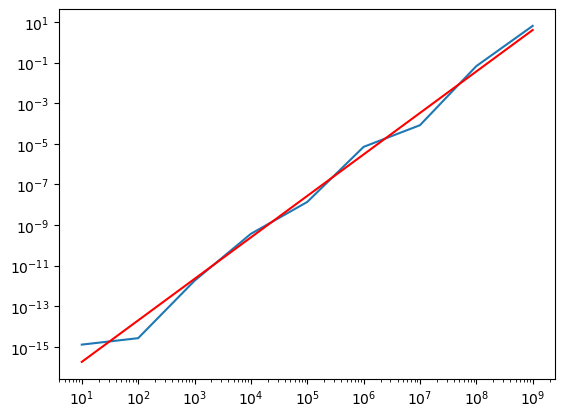

In [31]:
plt.loglog(c_errors, errors,label='Relative Error')
plt.loglog(c_errors, 10**bf[1] * (c_errors**bf[0]), color='r')
plt.show()